In [15]:
# imports

from torchvision import transforms
from torchinfo import summary
from torch import hub, device, cuda, load, Tensor, nn, cat, from_numpy, argmax, mean
import torch
from torch.utils.data import DataLoader
from timm.data import resolve_model_data_config, create_transform

import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
import numpy as np
import os
import csv
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from collections import OrderedDict
import sys
sys.path.append(r'/home/stud/afroehli/coding/util_scripts')
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

device = device('cuda' if cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cuda


In [2]:
# util objects

imagenet_info = ImagenetSemanticInfo()

Stop node discovered


In [3]:
with open('/home/stud/afroehli/datasets/imagenet_v2_label_transform/imagenet_1k_label_order.txt', 'r') as label_order_file:
    inet_1k_labels = label_order_file.readlines()
    inet_1k_labels = [label_order_line.split()[0] for label_order_line in inet_1k_labels]

In [4]:
class_a_b_map = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'r') as class_split_table:
    closest_pairs_timm_trans = csv.reader(class_split_table, delimiter=';')

    for class_a, class_b in closest_pairs_timm_trans:
        class_a_b_map[class_a] = class_b

In [5]:
# load model

vision_transformer = hub.load('facebookresearch/dinov2', 'dinov2_vits14')
vision_transformer.eval()
vision_transformer.to(device)

pretr_head = load('/home/stud/afroehli/coding/dinov2_ood/pretrained_heads/dinov2_vits14_linear_head.pth')
pretr_head_big = load('/home/stud/afroehli/coding/dinov2_ood/pretrained_heads/dinov2_vits14_linear4_head.pth')

Using cache found in /home/stud/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/stud/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/stud/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/stud/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/tmp/ipykernel_130415/3623471140.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

In [6]:
# experiments
#print(pretr_head)
#summary(pretr_head)
print(pretr_head['weight'].size())
print(pretr_head['weight'].shape)
cls_head = pretr_head['weight'][:,0:384]
print(cls_head.shape)
print(pretr_head['bias'].size())
print(pretr_head_big['weight'].size())
print(pretr_head_big['bias'].size())
print(pretr_head_big.keys())

torch.Size([1000, 768])
torch.Size([1000, 768])
torch.Size([1000, 384])
torch.Size([1000])
torch.Size([1000, 1920])
torch.Size([1000])
odict_keys(['weight', 'bias'])


In [4]:
base_path = '/home/stud/afroehli/datasets/ImageNet1k/imagenet1k/ILSVRC/Data/CLS-LOC/val_sorted/n01484850'
imgs_pths_one_class = os.listdir(base_path)

timm_model = 'vit_small_patch14_dinov2'
timm_model_conf = resolve_model_data_config(timm_model)
timm_model_conf['input_size'] = (3, 518, 518)

timm_transform = create_transform(**timm_model_conf, is_training=False)

imgs_transformed = [timm_transform(Image.open(base_path + '/' + img_path)) for img_path in imgs_pths_one_class]

print(imgs_transformed[0].shape)

torch.Size([3, 518, 518])


In [6]:
from torch import nn

class LinearClassifier(nn.Module): 

    def __init__(self, in_features = 384, out_features = 1000):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features= in_features, out_features=out_features),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [13]:
test_lc = LinearClassifier()

print(test_lc.state_dict()['network.0.weight'].size())
print(test_lc.state_dict()['network.0.bias'].size())

torch.Size([1000, 384])
torch.Size([1000])


In [13]:
img_on_dev = imgs_transformed[0]
img_on_dev = img_on_dev.unsqueeze(0)
img_on_dev = img_on_dev.to(device)
patch_tokens = vision_transformer.get_intermediate_layers(img_on_dev, return_class_token=True)

print(patch_tokens[0][0].shape)
print(patch_tokens[0][1].shape)
# p_token_cpu = patch_tokens[0].cpu().detach().numpy()
# p_token_mean = np.mean(p_token_cpu, axis=1)
# print(p_token_mean.shape)

torch.Size([1, 1369, 384])
torch.Size([1, 384])


In [7]:
# DataSet for training LinearClassifier
# custom dataset: dictonary -> [(embedding, index_as_tensor)]

class DictionaryDataset(torch.utils.data.Dataset): 
    
    """
    Pararms:
    1) data: complete dataset provided as dict
    2) index_list: list of data_dict-keys, order of keys in list will be used to create a tensor as the expected model-output
    """

    def __init__(self, data: dict, index_list: list[str]): 
        self.data_dict = data
        self.index_list = index_list 
        self.wnid_list = list(self.data_dict.keys())
        self.wnid_iterator = iter(self.wnid_list)
        self.instance_per_wnid = [len(self.data_dict[key]) for key in self.wnid_list]

    def __len__(self) -> int: 
        total_len = 0 
        for key in self.wnid_list:
            total_len += len(self.data_dict[key])

        return total_len 
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]: 

        sum_instances = 0
        sum_rest = 0

        # start with first wnid in list
        new_wnid = ''

        # iterate until total of all already covered instances is bigger than index of interest
        # when class of interest is reached, condition will be false (sum_instances points to first element of next class)
        for wnid in self.wnid_list: 
            if sum_instances > idx:
                break 
            new_wnid = wnid 
            sum_rest = sum_instances 
            sum_instances += len(self.data_dict[wnid])

        # index within class is needed 
        # fixed order: [class1, class2, ...]
        # when lenght of each previously covered class is known, index within class of interest can be calculated 
        # sum_rest always represent the total of instances of all covered classes yet, not of interest
        idx_within_class = idx - sum_rest

        np_arr = self.data_dict[new_wnid][idx_within_class]
        data_tensor = torch.tensor(np.array(np_arr))

        label_tensor = torch.zeros(len(self.index_list))
        # put a one at the position for the expected class 
        label_tensor[self.index_list.index(new_wnid)] = 1 

        return data_tensor, label_tensor

In [8]:
with open('/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_1k_val_pt_timm_trans.pkl', 'rb') as pkl_fl:
    inet_1k_pt_data = pickle.load(pkl_fl)

inet_1k_pt_dataset = DictionaryDataset(data = inet_1k_pt_data, index_list=inet_1k_labels)
inet_1k_pt_dataloader = DataLoader(dataset=inet_1k_pt_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [9]:

class_a_tensor = torch.zeros(len(inet_1k_labels))

for class_a_wnid in class_a_b_map.keys():
    pos = inet_1k_labels.index(class_a_wnid)
    class_a_tensor[pos] = 1

In [10]:


model_params_one_layer = OrderedDict()
model_params_four_layers = OrderedDict()
model_params_cls_token = OrderedDict()
model_params_one_layer['network.0.weight'] = pretr_head['weight']
model_params_one_layer['network.0.bias'] = pretr_head['bias']
model_params_cls_token['network.0.weight'] = pretr_head['weight'][:,0:384]
model_params_cls_token['network.0.bias'] = pretr_head['bias']
model_params_four_layers['network.0.weight'] = pretr_head_big['weight']
model_params_four_layers['network.0.bias'] = pretr_head_big['bias']

lc_one_layer = LinearClassifier(in_features=768, out_features=1000)
lc_cls_token = LinearClassifier(in_features=384, out_features=1000)
lc_four_layer = LinearClassifier(in_features=1920, out_features=1000)

lc_one_layer.load_state_dict(model_params_one_layer)
lc_cls_token.load_state_dict(model_params_cls_token)
lc_four_layer.load_state_dict(model_params_four_layers)

lc_one_layer.eval()
lc_cls_token.eval()
lc_four_layer.eval()

lc_one_layer.to(device)
lc_cls_token.to(device)
lc_four_layer.to(device)

acc_per_class = dict()

# for each lc calculate accuracy on INet-1k Val 

with torch.no_grad():
    for lc_model, lc_name in [(lc_one_layer, 'LC_ONE_LAYER'), (lc_cls_token, 'LC_CLS_TOKEN'), (lc_four_layer, 'LC_FOUR_LAYER')]:

        correct_preds = 0
        total_preds = 0
        pred_arr = []
        label_arr = []

        acc_per_class[lc_name] = dict()
        for class_a_wnid in class_a_b_map.keys():
            acc_per_class[lc_name][class_a_wnid] = {'true_pred': 0, 'total_pred': 0, 'acc': 0, 'm_smax': np.zeros(1000)}

        for batch in inet_1k_pt_dataloader:
            
            batch_samples = batch[0]
            batch_labels = batch[1]
            if lc_name == 'LC_ONE_LAYER':
                batch_samples_dev = cat([cat((batch_sample[3][1].squeeze(), batch_sample[3][0].squeeze())).unsqueeze(0)
                                    for batch_sample in batch_samples]).to(device)
            elif lc_name == 'LC_CLS_TOKEN':
                batch_samples_dev = cat([batch_sample[3][1] for batch_sample in batch_samples]).to(device)
            elif lc_name == 'LC_FOUR_LAYER':
                batch_samples_dev = cat([cat(((cat([cls_token for _, cls_token in batch_sample], dim=-1),
                    batch_sample[3][0])), dim=-1)
                    for batch_sample in batch_samples]).to(device)
            else:
                raise ValueError(f'Name of lc not defined: {lc_name}')
            
            lc_preds = lc_model(batch_samples_dev)
            lc_preds = lc_preds.cpu()
            is_equal = batch_labels.argmax(axis=1) == lc_preds.argmax(axis=1) 
            correct_preds += is_equal.type(torch.float).sum().item()
            total_preds += is_equal.size(0)
            
            # detect class_a examples by label 
            for i in range(0, batch_labels.shape[0]):
                is_class_a = torch.logical_and(batch_labels[i, :], class_a_tensor).nonzero()
                if is_class_a.numel() == True:
                    matching_index = is_class_a[0].item()
                    matching_wnid = inet_1k_labels[matching_index]
                    if is_equal[i].item(): 
                        acc_per_class[lc_name][matching_wnid]['true_pred'] += 1
                    acc_per_class[lc_name][matching_wnid]['total_pred'] += 1
                    acc_per_class[lc_name][matching_wnid]['m_smax'] = acc_per_class[lc_name][matching_wnid]['m_smax'] + np.array(lc_preds[i])

            pred_arr.append(lc_preds)
            label_arr.append(batch_labels)

        acc_model = correct_preds / total_preds 
        print(f'Accuracy of model {lc_name}: {acc_model}')

        for class_a_wnid in class_a_b_map.keys():
            acc_per_class[lc_name][class_a_wnid]['acc'] = float(acc_per_class[lc_name][class_a_wnid]['true_pred']) / 50
            acc_per_class[lc_name][class_a_wnid]['m_smax'] = acc_per_class[lc_name][class_a_wnid]['m_smax'] / 50
            
        #sk_acc = accuracy_score(label_arr, [p_acc.cpu() for p_acc in pred_arr], normalize=True)
        #print(f'SK acc: {sk_acc}')

Accuracy of model LC_ONE_LAYER: 0.81774
Accuracy of model LC_CLS_TOKEN: 0.74644
Accuracy of model LC_FOUR_LAYER: 0.80774


In [13]:
class_a_wnids = list(class_a_b_map.keys())
class_a_test = class_a_wnids[0:5]


for class_a in class_a_test:

    sorted_smax = np.argsort(acc_per_class['LC_ONE_LAYER'][class_a]['m_smax'])
    print(f'Class-A: {imagenet_info.wnid_to_classname[class_a]}, Max-4: {[imagenet_info.wnid_to_classname[inet_1k_labels[pos.item()]] for pos in sorted_smax[-4:]]}')

Class-A:  strawberry, Max-4: [' pineapple', ' pomegranate', ' trifle', ' strawberry']
Class-A:  peafowl, Max-4: [' spider web', ' macaw', ' quill', ' peafowl']
Class-A:  Labrador Retriever, Max-4: [' tennis ball', ' Flat-Coated Retriever', ' Golden Retriever', ' Labrador Retriever']
Class-A:  monarch butterfly, Max-4: [' cardoon', ' lemon', ' red admiral butterfly', ' monarch butterfly']
Class-A:  giant panda, Max-4: [' soap dispenser', ' badger', ' teddy bear', ' giant panda']


In [11]:
# for each class-a mean softmax 

# calculate diffs: class-a -> class-b, class-a -> nearest class not class-b 

softmax_diffs = dict()

wrong_max_sm = []

for class_a_wnid in class_a_b_map.keys():

    softmax_diffs[class_a_wnid] = {'class_b_diff': [tuple], 'next_class_diff': [tuple]}

    class_b_wnid = class_a_b_map[class_a_wnid]
    class_a_index = inet_1k_labels.index(class_a_wnid)
    class_b_index = inet_1k_labels.index(class_b_wnid)

    class_a_sm = acc_per_class['LC_ONE_LAYER'][class_a_wnid]['m_smax']
    class_a_sm_val = class_a_sm[inet_1k_labels.index(class_a_wnid)]
    sm_arr_class_a_val = np.array([class_a_sm_val for i in range(1000)])
    diff_to_class_a_val = np.subtract(sm_arr_class_a_val, class_a_sm) 

    diff_b_val = diff_to_class_a_val[inet_1k_labels.index(class_b_wnid)]
    softmax_diffs[class_a_wnid]['class_b_diff'] = (class_b_wnid, diff_b_val) 

    min_diff_indices = np.argsort(diff_to_class_a_val)

    for min_diff_index in min_diff_indices:
        if not min_diff_index in [class_a_index, class_b_index]: 
            # print(inet_1k_labels[min_diff_index])
            # print(f'Next class: {imagenet_info.wnid_to_classname[inet_1k_labels[min_diff_index]]}')
            next_lowest_diff = diff_to_class_a_val[min_diff_index]
            
            next_class_wnid = inet_1k_labels[min_diff_index]
            softmax_diffs[class_a_wnid]['next_class_diff'] = (next_class_wnid, next_lowest_diff)
            break


In [22]:
# calculate l1-distances for class-b and next_nearest-class to class-a 

comp_l1_dists = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_b_next_nearest.csv', 'r') as csv_file:
    with open('/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_1k_val_timm_trans.pkl', 'rb') as pkl_fl: 

        inet_1k_val_res = pickle.load(pkl_fl)

        csv_reader = csv.reader(csv_file, delimiter=';')
        for n, (class_a_wnid, class_b_wnid, nn_class_wnid) in enumerate(csv_reader):
            if n != 0: 
                class_a_mean_emb = np.mean(inet_1k_val_res[class_a_wnid], axis=0)
                class_b_mean_emb = np.mean(inet_1k_val_res[class_b_wnid], axis=0)
                nn_class_mean_emb = np.mean(inet_1k_val_res[nn_class_wnid], axis=0)


                comp_l1_dists[class_a_wnid] = {'class_b': np.sum(np.abs(class_a_mean_emb - class_b_mean_emb)), 
                                               'nn_class': np.sum(np.abs(class_a_mean_emb - nn_class_mean_emb))}
        

<Axes: >

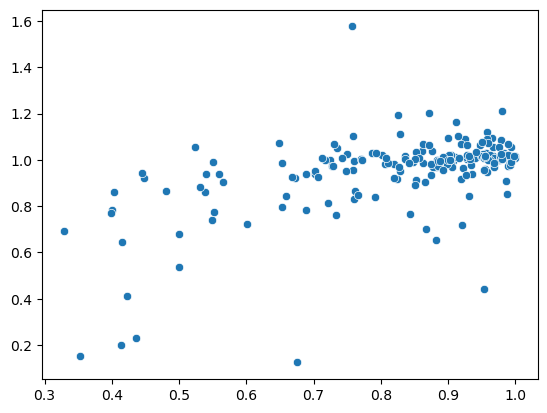

In [24]:
x_data = []
y_data = []

for class_a in comp_l1_dists.keys():
    x_data.append((comp_l1_dists[class_a]['class_b'] / comp_l1_dists[class_a]['nn_class']).item())
    y_data.append((softmax_diffs[class_a]['class_b_diff'][1] / softmax_diffs[class_a]['next_class_diff'][1]).item())

sns.scatterplot(x=x_data, y=y_data)

In [13]:
# store results for softmax-diff in csv-file 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/softmax_diffs.csv', 'w', newline='') as csv_fl: 
    csv_writer = csv.writer(csv_fl, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B', 'Diff-CB', 'Class-Next', 'Diff-CN'])

    for class_a_wnid in softmax_diffs.keys():
        next_row = [imagenet_info.wnid_to_classname[class_a_wnid], 
                    imagenet_info.wnid_to_classname[softmax_diffs[class_a_wnid]['class_b_diff'][0]],
                    softmax_diffs[class_a_wnid]['class_b_diff'][1], 
                    imagenet_info.wnid_to_classname[softmax_diffs[class_a_wnid]['next_class_diff'][0]],
                    softmax_diffs[class_a_wnid]['next_class_diff'][1]]
        csv_writer.writerow(next_row)

In [12]:
lc_one_layer_acc = []
lc_only_cls_acc = []
lc_four_layer_acc = []

for acc_list, lc_name in [(lc_one_layer_acc, 'LC_ONE_LAYER'), (lc_only_cls_acc, 'LC_CLS_TOKEN'), (lc_four_layer_acc, 'LC_FOUR_LAYER')]: 
    for class_a_wnid in class_a_b_map.keys():
        acc_list.append((acc_per_class[lc_name][class_a_wnid]['acc'], imagenet_info.wnid_to_classname[class_a_wnid]))

    print(lc_name)
    acc_list.sort(key=lambda x: x[0])
    print(acc_list)


LC_ONE_LAYER
[(0.38, ' bathtub'), (0.44, ' mushroom'), (0.52, ' Toy Poodle'), (0.54, ' vase'), (0.54, ' Bloodhound'), (0.58, ' backpack'), (0.58, ' Siberian Husky'), (0.6, ' Border Collie'), (0.6, ' cauldron'), (0.6, ' flute'), (0.62, ' missile'), (0.64, ' grasshopper'), (0.64, ' red fox'), (0.64, ' hatchet'), (0.64, ' bucket'), (0.64, ' assault rifle'), (0.64, ' cowboy hat'), (0.66, ' smooth newt'), (0.68, ' wine bottle'), (0.68, ' grand piano'), (0.7, ' candle'), (0.7, ' shield'), (0.7, ' tabby cat'), (0.7, ' hammer'), (0.72, ' spider web'), (0.72, ' espresso'), (0.72, ' pig'), (0.72, ' lighthouse'), (0.72, ' ambulance'), (0.74, ' electric guitar'), (0.74, ' lipstick'), (0.74, ' beer glass'), (0.76, ' tank'), (0.76, ' collie'), (0.76, ' Chihuahua'), (0.76, ' pickup truck'), (0.76, ' eel'), (0.78, ' German Shepherd Dog'), (0.78, ' violin'), (0.78, ' ice cream'), (0.78, ' Yorkshire Terrier'), (0.78, ' Shih Tzu'), (0.8, ' cucumber'), (0.8, ' tennis ball'), (0.8, ' lemon'), (0.8, ' Scott

In [ ]:
# for all class-a instances create dataset and dataloader 

for class_a in class_a_b_map.keys():
    

In [10]:
preds = []

with torch.no_grad():
    for img in imgs_transformed: 

        last_layer = vision_transformer.get_intermediate_layers(img.unsqueeze(0).to(device), 1, return_class_token=True)
        m_pts = mean(last_layer[0][0], dim=1)
        comb_tensor = cat((last_layer[0][1].squeeze(),mean(last_layer[0][0], dim=1).squeeze())).unsqueeze(0).to(device)
        pred = lc_one_layer(comb_tensor)
        preds.append(pred.argmax(axis=1))

    print([scal.item() for scal in preds])

[2, 2, 2, 2, 2, 3, 2, 2, 2, 148, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 149, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2]


In [39]:
l4_layers = vision_transformer.get_intermediate_layers(imgs_transformed[0].unsqueeze(0).to(device), 4, return_class_token=True)
print(len(l4_layers))
for i in range(4):
    print(f'{i}: Layer')
    print(l4_layers[i][0].shape)
    print(l4_layers[i][1].shape)

output = cat([class_token for _, class_token in l4_layers], dim=-1)
print(output.shape)
if True:
        output = cat(
            (
                output,
                mean(l4_layers[-1][0], dim=1),  # patch tokens
            ),
            dim=-1,
        )
print(output.shape)
output = output.reshape(output.shape[0], -1)
print(output.shape)

single_layer = vision_transformer.get_intermediate_layers(imgs_transformed[0].unsqueeze(0).to(device), 0, return_class_token=True)
print(single_layer)
print(mean(single_layer[0][0], dim=1))
print(mean(l4_layers[-1][0], dim=1))

NameError: name 'imgs_transformed' is not defined